In [ ]:
!pip install -U imbalanced-learn

     |████████████████████████████████| 215kB 5.4MB/s 
     |████████████████████████████████| 22.3MB 1.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: imbalanced-learn 0.4.3
    Uninstalling imbalanced-learn-0.4.3:
      Successfully uninstalled imbalanced-learn-0.4.3


In [ ]:
import numpy as np
import keras
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras import callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import utils
import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN, SVMSMOTE,  KMeansSMOTE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import re
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [ ]:
train_X = []
train_Y = []

test_X = []
test_Y = []

with open('trainData.txt', "r+", encoding='utf-8') as f:
    for line in f:
        line = line.strip('\n').split('\t')
        # print(line)
        if len(line)==2:
          train_Y.append(line[1])
          train_X.append(line[0])

with open('testData.txt', "r+", encoding='utf-8') as f:
    for line in f:
        line = line.strip('\n').split('\t')
        if len(line)==2:
          test_Y.append(line[1])
          test_X.append(line[0])

In [ ]:
len(train_X)+len(test_X)

14373

Printing distribution of samples in the training dataset

In [ ]:
dic = {}

for t in train_Y:
  if int(t) not in dic:
    dic[int(t)] = 0
  dic[int(t)]+=1

print(dic)

{1: 2353, 0: 5890, 2: 1786}


In [ ]:
len(test_X)

4321

Baseline for SVM before oversampling

In [ ]:
from sklearn.svm import SVC
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf-svm', SVC()),  ])
text_clf_svm = text_clf_svm.fit(train_X, train_Y)

In [ ]:
target_names = ['NEG', 'NEU', 'POS']

predicted_svm = text_clf_svm.predict(test_X)
print ("svm", np.mean(predicted_svm == test_Y))
print(classification_report(test_Y, predicted_svm, target_names=target_names))


svm 0.8264290673455219
              precision    recall  f1-score   support

         NEG       0.83      0.98      0.90      3173
         NEU       0.71      0.29      0.41       643
         POS       0.87      0.57      0.69       505

    accuracy                           0.83      4321
   macro avg       0.80      0.61      0.66      4321
weighted avg       0.82      0.83      0.80      4321



PLotting the distribution for original dataset

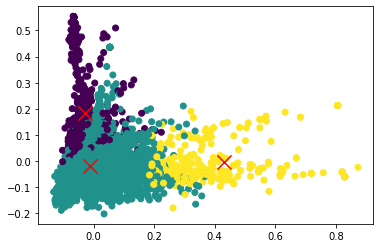

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])  
X = pipeline.fit_transform(train_X).todense()

kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.labels_.tolist()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)

plt.scatter(data2D[:,0], data2D[:,1], c=clusters)
centers2D = pca.transform(kmeans.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.show()   

TF-IDF vectors to be used for oversampling algorithms

In [ ]:

vects = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()) ])
train_vects = vects.fit_transform(train_X)

In [ ]:
test_vects = vects.transform(test_X)

In [ ]:
test_vects

<4321x12273 sparse matrix of type '<class 'numpy.float64'>'
	with 68695 stored elements in Compressed Sparse Row format>

SMOTE based oversampling

In [ ]:
smo = SMOTE( ratio=1.0)
smo_xtrain_tfidf, smo_train_y = ros.fit_sample(train_vects, train_Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
svmCL = SVC()
svmCL.fit(smo_xtrain_tfidf, smo_train_y)
predicted_svm = svmCL.predict(test_vects)
print ("svm", np.mean(predicted_svm == test_Y))
print(classification_report(test_Y, predicted_svm, target_names=target_names))

svm 0.8345290442027309
              precision    recall  f1-score   support

         NEG       0.85      0.96      0.90      3173
         NEU       0.67      0.38      0.49       643
         POS       0.82      0.64      0.72       505

    accuracy                           0.83      4321
   macro avg       0.78      0.66      0.70      4321
weighted avg       0.82      0.83      0.82      4321



Plotting the distribution for SMOTE

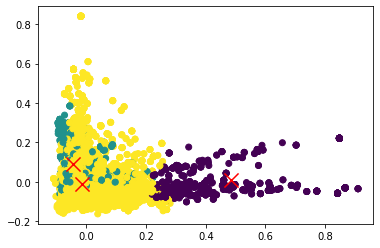

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


X = smo_xtrain_tfidf.todense()

kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.labels_.tolist()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)

plt.scatter(data2D[:,0], data2D[:,1], c=clusters)
centers2D = pca.transform(kmeans.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.show() 

ADASYN based oversampling

In [ ]:
ad = ADASYN(random_state=777) 
ad_xtrain_tfidf, ad_train_y = ad.fit_resample(train_vects, train_Y)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
svmCL = SVC()
svmCL.fit(ad_xtrain_tfidf, ad_train_y)
predicted_svm = svmCL.predict(test_vects)
print ("svm", np.mean(predicted_svm == test_Y))
print(classification_report(test_Y, predicted_svm, target_names=target_names))

svm 0.825271927794492
              precision    recall  f1-score   support

         NEG       0.83      0.97      0.90      3173
         NEU       0.68      0.29      0.41       643
         POS       0.88      0.57      0.69       505

    accuracy                           0.83      4321
   macro avg       0.80      0.61      0.67      4321
weighted avg       0.81      0.83      0.80      4321



Plotting the distribution for ADASYN

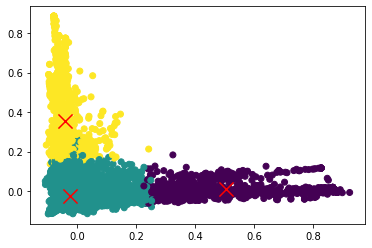

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


X = ad_xtrain_tfidf.todense()

kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.labels_.tolist()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)

plt.scatter(data2D[:,0], data2D[:,1], c=clusters)
centers2D = pca.transform(kmeans.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.show() 

SVMSMOTE based oversampling

In [ ]:
sm = SVMSMOTE(random_state=0)
sm_xtrain_tfidf, sm_train_y = sm.fit_resample(train_vects, train_Y)

In [ ]:
svmCL = SVC()
svmCL.fit(sm_xtrain_tfidf, sm_train_y)
predicted_svm = svmCL.predict(test_vects)
print ("svm", np.mean(predicted_svm == test_Y))
target_names =['NEG', 'NEU', 'POS']
print(classification_report(test_Y, predicted_svm, target_names=target_names))

svm 0.8287433464475816
              precision    recall  f1-score   support

         NEG       0.87      0.94      0.90      3173
         NEU       0.63      0.37      0.47       643
         POS       0.70      0.70      0.70       505

    accuracy                           0.83      4321
   macro avg       0.73      0.67      0.69      4321
weighted avg       0.81      0.83      0.81      4321



Plotting distribution for SVMSMOTE

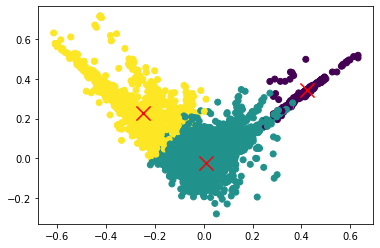

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


X = sm_xtrain_tfidf.todense()

kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.labels_.tolist()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)

plt.scatter(data2D[:,0], data2D[:,1], c=clusters)
centers2D = pca.transform(kmeans.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.show() 

KMeansSMOTE based oversampling

In [ ]:
km = KMeansSMOTE(random_state=0)
km_xtrain_tfidf, km_train_y = km.fit_resample(train_vects, train_Y)

In [ ]:
svmCL = SVC()
svmCL.fit(km_xtrain_tfidf, km_train_y)
predicted_svm = svmCL.predict(test_vects)
print ("svm", np.mean(predicted_svm == test_Y))
print(classification_report(test_Y, predicted_svm, target_names=target_names))

svm 0.8257347836149039
              precision    recall  f1-score   support

         NEG       0.83      0.97      0.90      3173
         NEU       0.69      0.30      0.42       643
         POS       0.87      0.56      0.68       505

    accuracy                           0.83      4321
   macro avg       0.80      0.61      0.67      4321
weighted avg       0.82      0.83      0.80      4321



Plotting the distribution for KMeansSMOTE

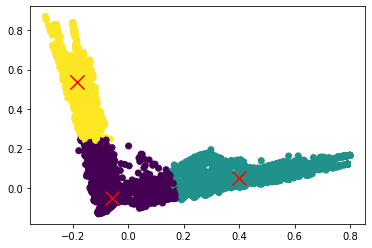

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


X = km_xtrain_tfidf.todense()

kmeans = KMeans(n_clusters=3).fit(X)
clusters = kmeans.labels_.tolist()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)

plt.scatter(data2D[:,0], data2D[:,1], c=clusters)
centers2D = pca.transform(kmeans.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')
plt.show() 